<a href="https://colab.research.google.com/github/giuliovv/ANNDL_competitions/blob/master/2_RNN/toma_model_stride_5_window_3000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to drive and import libraries

In [1]:
import os

colab = "True" #@param ['True','False']
if colab == "True":
  from google.colab import drive
  drive._mount('/gdrive')
  %cd /gdrive/MyDrive/Colab Notebooks

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np

tfk = tf.keras
tfkl = tf.keras.layers

### Data inspection

In [3]:
plt.rcParams["figure.figsize"] = (20,10)
data = pd.read_csv("Training.csv")
data.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
Sponginess,1.000000,0.253002,0.297509,0.121744,0.331200,0.127885,0.183141
Wonder level,0.253002,1.000000,0.119078,0.930254,0.367438,0.237021,0.074392
Crunchiness,0.297509,0.119078,1.000000,0.067477,0.029108,0.061539,0.987209
Loudness on impact,0.121744,0.930254,0.067477,1.000000,0.056184,0.229336,0.048806
Meme creativity,0.331200,0.367438,0.029108,0.056184,1.000000,0.078168,-0.040596
Soap slipperiness,0.127885,0.237021,0.061539,0.229336,0.078168,1.000000,0.050996
Hype root,0.183141,0.074392,0.987209,0.048806,-0.040596,0.050996,1.000000


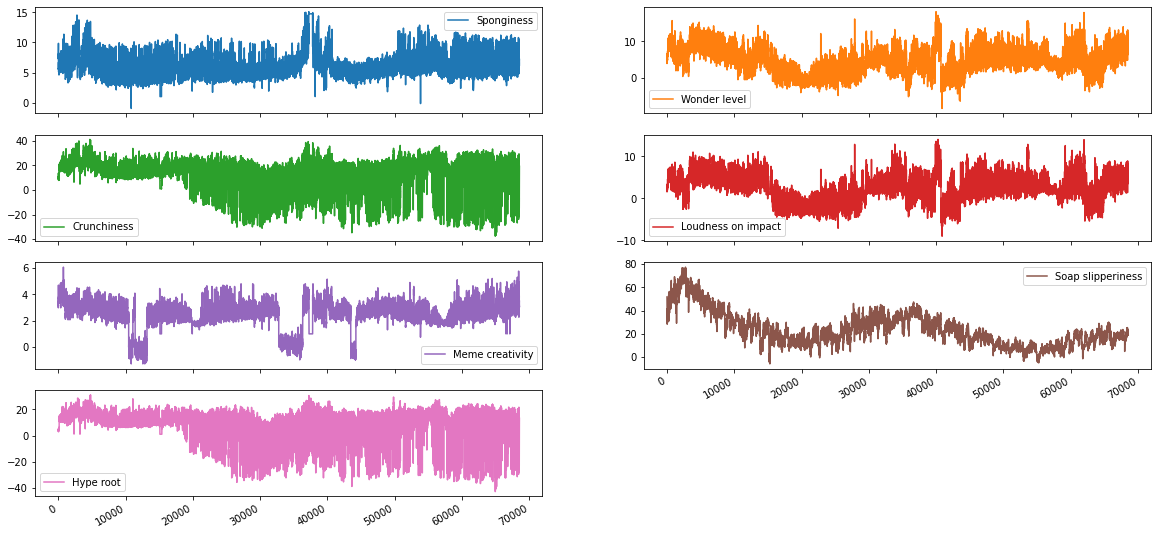

In [5]:
data.plot(subplots=True, layout=(4,2))
data.corr().style.background_gradient(cmap='coolwarm')


### Set seed for reproducibility

In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# data_or = data
# data = data.drop(["Hype root", "Loudness on impact"], axis=1)

### Seasonality removal

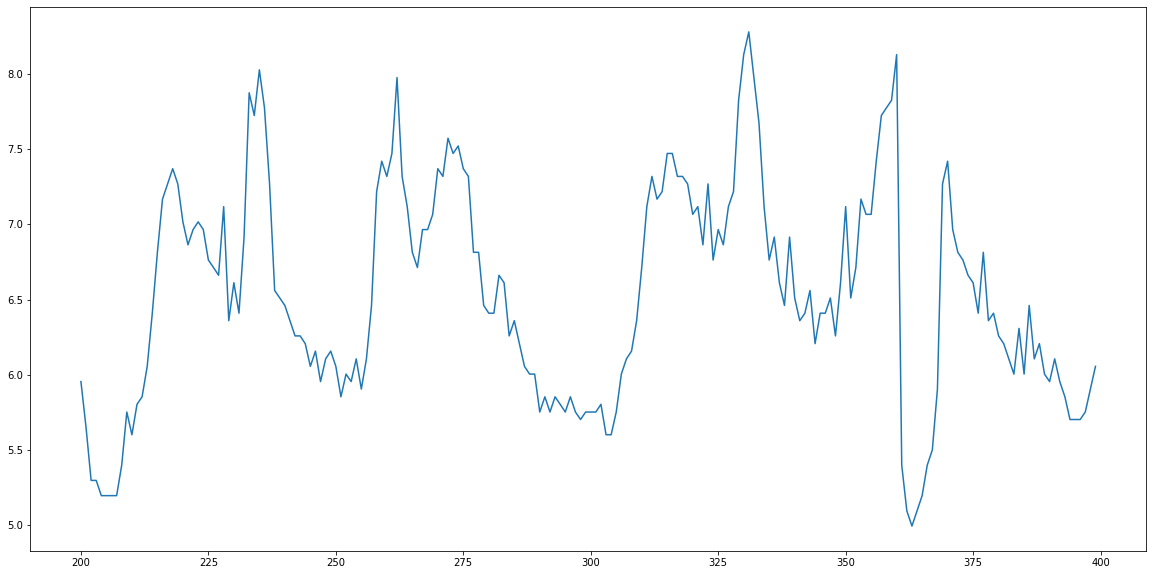

In [8]:
data.Sponginess.iloc[200:400].plot()

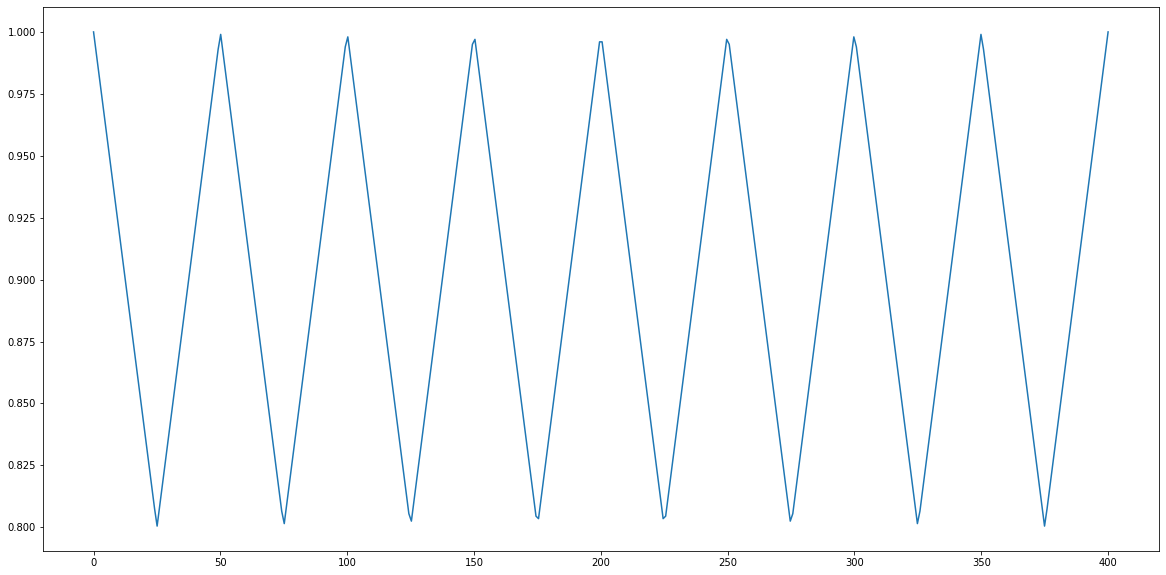

In [9]:
def seas(x, shift=25, diff=0.8, length=50):
  x = x+shift
  invert = 1 if x%length < length/2 else 0
  moment = abs(invert - (x%(length/2))/(length/2))
  return 1 - (1-diff)*moment
plt.plot(np.linspace(0, 400, 400), [seas(x) for x in np.linspace(0, 400, 400)])

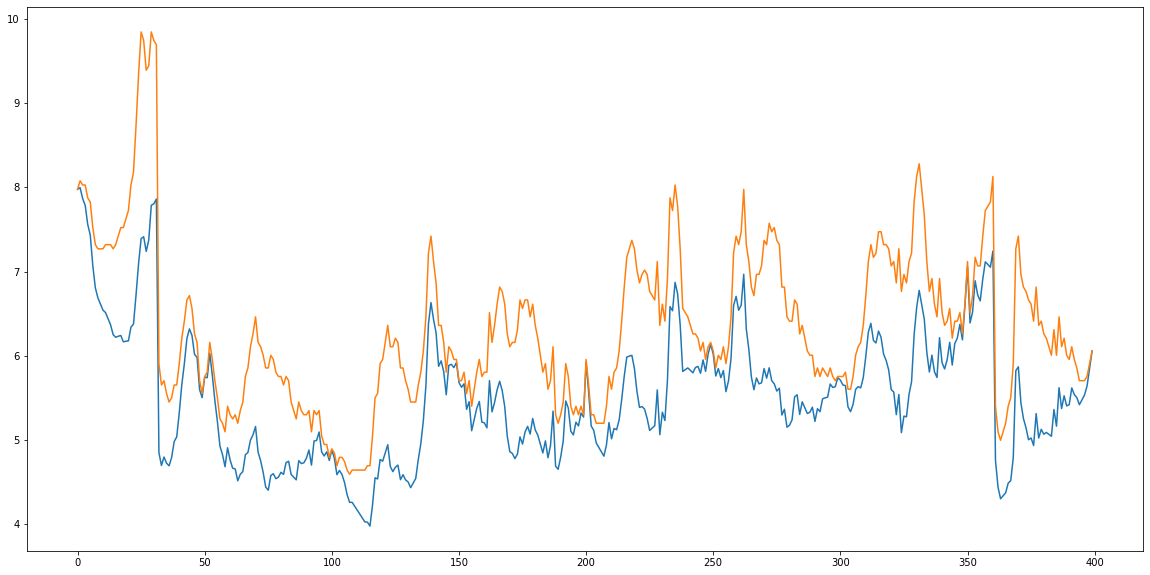

In [10]:
shift = int(data.Sponginess.iloc[0:100].argmax())
length = data.Sponginess.iloc[int(2*shift):int(4*shift)].argmax() + 2*shift
(data.Sponginess.iloc[0:400] * pd.Series([seas(x, shift=shift, diff=0.75, length=50) for x in np.linspace(0, 400, 400)])).plot()
data.Sponginess.iloc[0:400].plot()

In [11]:
length

70

In [12]:
shift

25

### Creating training and testing data

(54823, 7) (13705, 7)


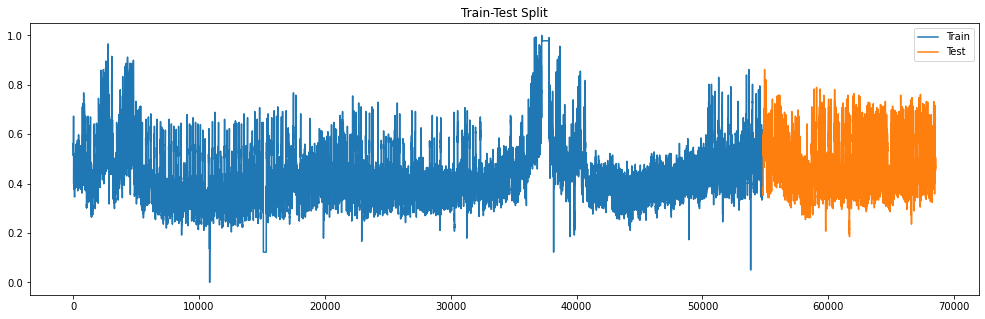

In [13]:
TEST_SPLIT = 0.2

test_size = int(len(data)*TEST_SPLIT)
X_train_raw = data.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = data.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

# Normalize soap sliperiness
# X_sloap_slip = X_train_raw["Soap slipperiness"]
# X_train_raw["Soap slipperiness"] = (X_sloap_slip - X_sloap_slip.min())/(X_sloap_slip.max()-X_sloap_slip.min())
# X_test_raw["Soap slipperiness"] = (X_test_raw["Soap slipperiness"] - X_sloap_slip.min())/(X_sloap_slip.max()-X_sloap_slip.min())

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train')
plt.plot(X_test_raw['Sponginess'], label='Test')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [14]:
window = 3000
stride = 5

In [15]:
future = data[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 3000, 7)

In [16]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100, seasonality_removal=False):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    if not seasonality_removal:
        for idx in np.arange(0,len(temp_df)-window-telescope,stride):
          dataset.append(temp_df[idx:idx+window])
          labels.append(temp_label[idx+window:idx+window+telescope])
    else:
        for idx in np.arange(0,len(temp_df)-window-telescope,stride):
            next_seq = temp_df[idx:idx+window]
            # shift = int(next_seq[0:100].argmax())
            # factor = np.array([seas(x, shift=shift, diff=0.75, length=50) for x in range(len(next_seq))])
            # dataset.append(next_seq * factor[:, np.newaxis])
            dataset.append(next_seq)
            labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [17]:
target_labels = data.columns
telescope = 864

In [18]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope, seasonality_removal=True)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope, seasonality_removal=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10628, 3000, 7), (10628, 864, 7), (2228, 3000, 7), (2228, 864, 7))

In [19]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

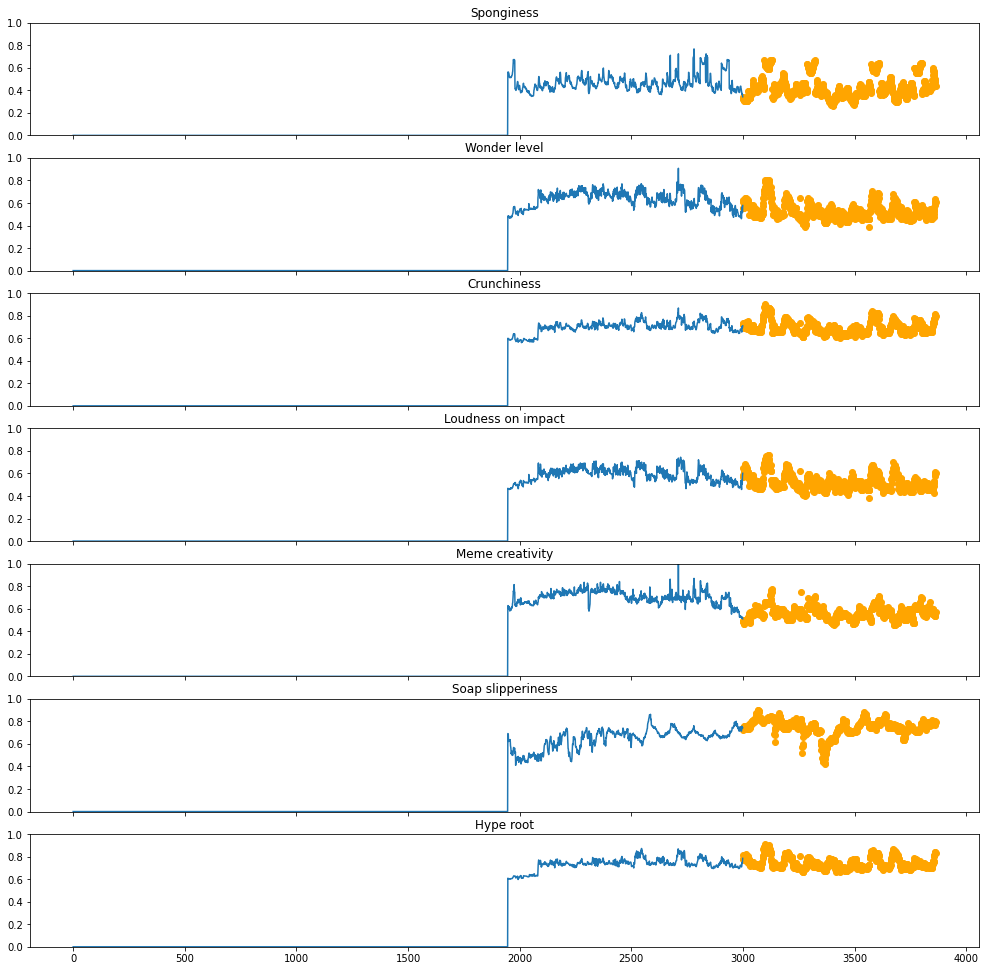

In [20]:
inspect_multivariate(X_train, y_train, target_labels, telescope, idx=46)

In [21]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 200

Results:
BI(LSTM(64)) 
c1d
maxpool
BI(LSTM(128))
c1d
averagepool
dropout
0.0093

### Building network (Multivariate forecasting-direct)

In [22]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.LayerNormalization(epsilon=1e-6)(input_layer)

    convlstm = tfkl.Bidirectional(tfkl.GRU(528, return_sequences=True))(x)
    convlstm = tfkl.Conv1D(128, 7, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPooling1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.GRU(528, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 7, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    convlstm = tfkl.LayerNormalization(epsilon=1e-6)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3000, 7)]         0         
                                                                 
 layer_normalization (LayerN  (None, 3000, 7)          14        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 3000, 1056)       1701216   
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 3000, 128)         946304    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1500, 128)        0         
 )                                                               
                                                             

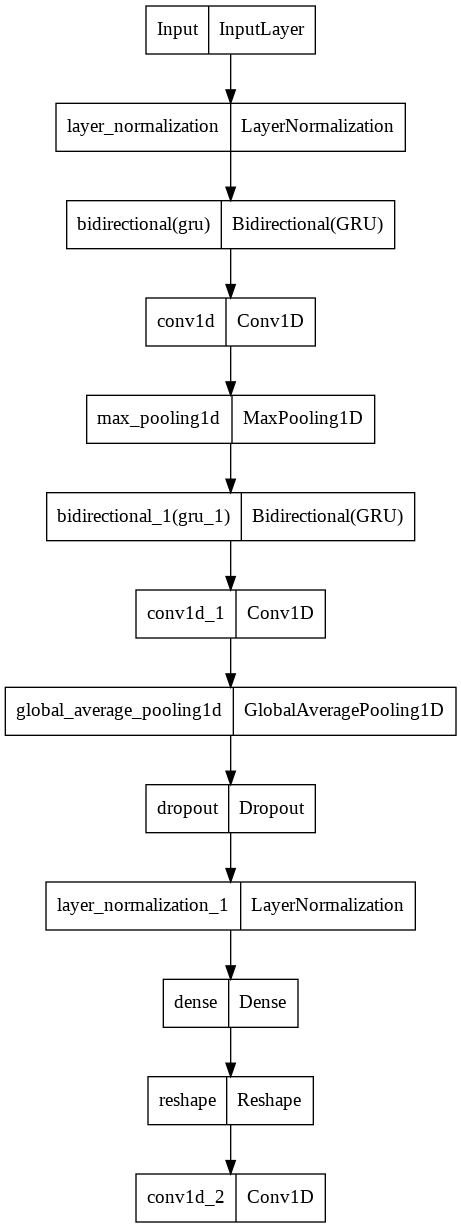

In [23]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tf.keras.utils.plot_model(model, expand_nested=True)

In [24]:
br_callback = tf.keras.callbacks.experimental.BackupAndRestore(
    "gru_backup_stride_5_window_3000"
)


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        br_callback
    ]
).history

Epoch 24/200
299/299 [==============================] - 1057s 4s/step - loss: 0.0076 - mae: 0.0647 - root_mean_squared_error: 0.0875 - val_loss: 0.0113 - val_mae: 0.0808 - val_root_mean_squared_error: 0.1064 - lr: 0.0010
Epoch 25/200
148/299 [=============>................] - ETA: 8:27 - loss: 0.0075 - mae: 0.0642 - root_mean_squared_error: 0.0868

In [26]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

NameError: ignored

In [27]:
model.save('gru_window_3000_stride_5')
# model = tfk.models.load_model('DirectForecasting')

INFO:tensorflow:Assets written to: gru_window_3000_stride_5/assets


INFO:tensorflow:Assets written to: gru_window_3000_stride_5/assets


In [28]:
X_test_raw.shape

(13705, 7)

In [29]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error.numpy(), mean_absolute_error.numpy()

(2228, 864, 7)


(0.017619593, 0.09697539)

In [30]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

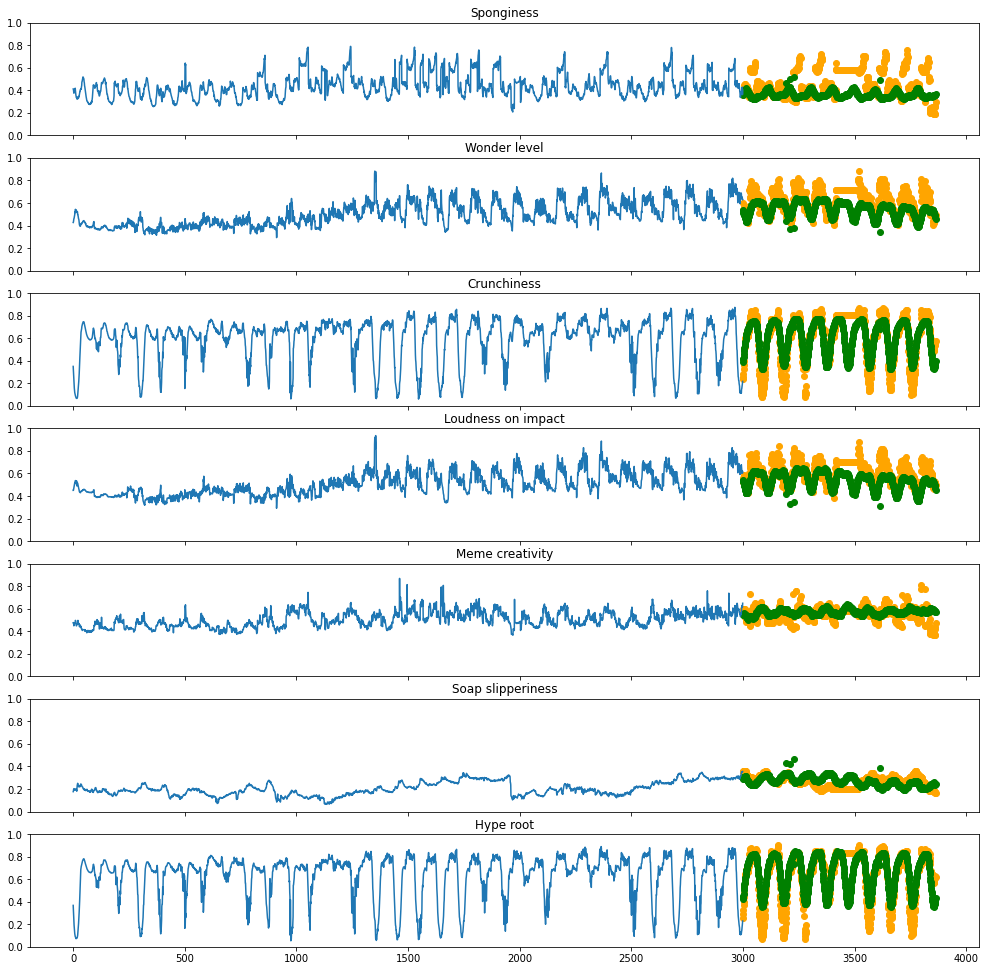

In [31]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [32]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [33]:
future_predictions = model.predict(future)

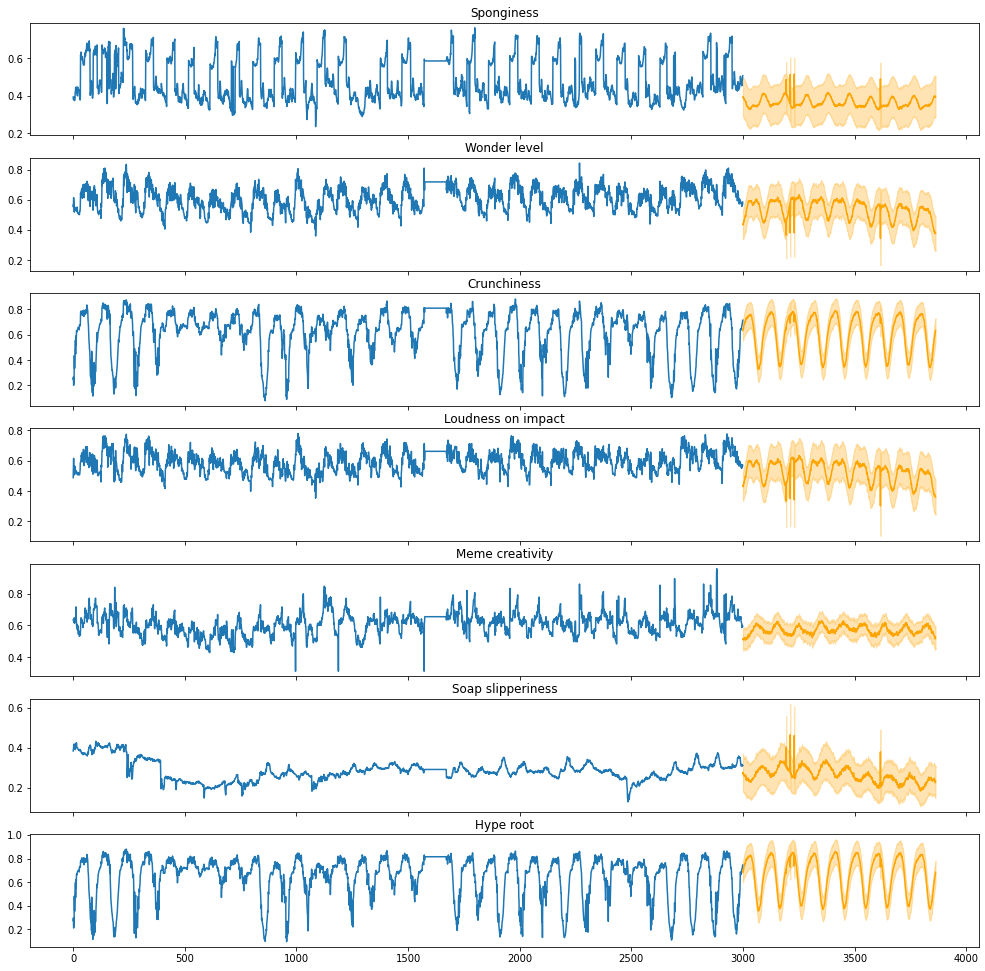

In [34]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()